In [1]:
import os
import sys
import pathlib
import numpy as np
import pandas as pd
import sklearn
from functools import partial
from MulticoreTSNE import MulticoreTSNE as TSNE
# from sklearn.manifold import TSNE
from sklearn.cluster import KMeans, DBSCAN
from scipy.spatial.distance import cdist
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import datashader as ds
import datashader.transfer_functions as dtf
from datashader.mpl_ext import dsshow

# Make TensorFlow log less verbose
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "3"

import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow.keras.initializers import RandomNormal, GlorotUniform
from tensorflow.keras.optimizers import SGD, Adam
from tensorflow.keras.losses import kl_divergence

import umap
import hdbscan
from mdutils.mdutils import MdUtils

FLP_path = pathlib.Path('/home/STUDENTI/lorenzo.sani/Federated-Learning-Project').absolute()
sys.path.insert(1, str(FLP_path))

from py.dec.util import create_denoising_autoencoder, create_clustering_model, target_distribution#, print_confusion_matrix, plot_lifelines_pred
import py.metrics as my_metrics
from py.util import compute_centroid_np, get_dims_from_weights

results_path = pathlib.Path('/home/STUDENTI/lorenzo.sani/Federated-Learning-Project/mnist_adam_norminit/output_mnist')
N_CLUSTERS = 10

# gpus = tf.config.list_physical_devices('GPU')
# tf.config.set_visible_devices(gpus, 'GPU')
# disable possible gpu devices for this kernel
tf.config.set_visible_devices([], 'GPU')

/home/STUDENTI/lorenzo.sani/mambaforge/envs/logu/lib/python3.9/site-packages/tensorflow_addons/utils/ensure_tf_install.py:53: UserWarning: Tensorflow Addons supports using Python ops for all Tensorflow versions above or equal to 2.4.0 and strictly below 2.7.0 (nightly versions are not supported). 
 The versions of TensorFlow you are currently using is 2.7.0 and is not supported. 
Some things might work, some things might not.
If you were to encounter a bug, do not file an issue.
If you want to make sure you're using a tested and supported configuration, either change the TensorFlow version or the TensorFlow Addons's version. 
You can find the compatibility matrix in TensorFlow Addon's readme:
https://github.com/tensorflow/addons
  warnings.warn(


In [2]:
# prefix = 'aggregated_weights_'
encoder_param = np.load(results_path/str('encoder.npz'),
                        allow_pickle=True)
encoder_param = np.squeeze(np.array([encoder_param[p] for p in encoder_param]))
encoder_ft_param = np.load(results_path/str('encoder_ft.npz'),
                           allow_pickle=True)
encoder_ft_param = np.squeeze(np.array([encoder_ft_param[p] for p in encoder_ft_param]))
encoder_final_param = np.load(results_path/str('encoder_final.npz'),
                              allow_pickle=True)
encoder_final_param = np.squeeze(np.array([encoder_final_param[p] for p in encoder_final_param]))
initial_centroids = np.load(results_path/'initial_centroids.npz',
                            allow_pickle=True)
initial_centroids = np.squeeze(np.array([initial_centroids[p] for p in initial_centroids]))
final_centroids = np.load(results_path/str('final_centroids.npz'),
                          allow_pickle=True)
final_centroids = np.squeeze(np.array([final_centroids[p] for p in final_centroids]))

In [3]:
print('Initial Centroids: {}'.format(initial_centroids))
print('Final Centroids: {}'.format(final_centroids))
delta_centroids = final_centroids-initial_centroids
print('Delta Centroids: {}'.format(delta_centroids))

Initial Centroids: [[ 22.56743654 -24.70060145 -31.64055314 -26.50517424 -24.62689059
   46.33671004  30.04261288 -36.53718988  -5.88930518  30.81053755]
 [  8.99639127  -8.23967699 -16.45382068 -15.21851225  -8.94879425
   19.33747136  14.37665746 -16.35932502   2.64927636  13.7810109 ]
 [ 15.01243601 -18.6774153  -22.7527876  -19.83429821 -20.19555333
   30.91271407  22.62926052 -26.18903574  -3.71301191  22.45450019]
 [ 20.61781724   2.76312247 -10.8267442  -23.73753112 -16.64522211
   15.99079281   8.90470158 -32.16820027  -8.07129971  18.58664689]
 [ 41.93490157 -16.90849351 -42.95931993 -30.53413667 -14.70059755
   44.38885686  31.60427278 -41.82500172  -6.71477492  30.49863841]
 [  8.75595763 -18.83831179 -13.4019908  -11.44666423 -31.47049223
   40.88017412  20.62201117 -20.02276163   8.50506774  18.68300425]
 [ 12.09422829  -4.48799671 -13.3078258  -14.16513801 -19.44551328
   25.99421448  14.15830128 -16.64159053   4.00993283  22.37751422]
 [ 12.94924005  -6.15140149 -21.5651

In [4]:
# preparing dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
n_features = int(x_train.shape[1]*x_train.shape[1])
x_train, x_test = x_train.reshape(x_train.shape[0], n_features), x_test.reshape(x_test.shape[0], n_features)

In [5]:
# setting up the autoencoder
dims = get_dims_from_weights(encoder_param)
config = {
    'batch_size': 256,
    'n_clusters': 10,
    'kmeans_n_init': 20,
    'ae_epochs': 50000,
    'ae_optimizer': SGD(
        learning_rate=0.1,
        momentum=0.9,
        decay=(0.1-0.0001)/50000),
    # 'ae_optimizer': Adam(),
    'ae_dims': dims,
    'ae_act': 'relu',
    # 'ae_init': RandomNormal(mean=0.0,
    #                         stddev=0.01),
    'ae_init': GlorotUniform(seed=51550),
    'is_tied': True,
    'u_norm_reg': False,
    'ortho_w_con': False,
    'uncoll_feat_reg': False,
    'use_bias': True,
    'dropout_rate': 0.0,
    'noise_rate': 0.0,
    'ran_flip_conf': None,
    'ae_metrics': [
        my_metrics.rounded_accuracy,
    ],
    'cl_optimizer': SGD(
        learning_rate=0.01,
        momentum=0.9),
    'update_interval': 160,
    'ae_loss': 'mse',
    'cl_loss': 'kld',
    'seed': 51550}

autoencoder, encoder, decoder = create_denoising_autoencoder(
    flavor='real',
    dims=config['ae_dims'],
    activation=config['ae_act'],
    w_init=config['ae_init'],
    is_tied=config['is_tied'],
    u_norm_reg=config['u_norm_reg'],
    ortho_w_con=config['ortho_w_con'],
    uncoll_feat_reg=config['uncoll_feat_reg'],
    use_bias=config['use_bias'],
    dropout_rate=config['dropout_rate'],
    noise_rate=config['noise_rate'],
    ran_flip_conf=None,
    )

autoencoder.compile(
    metrics=config['ae_metrics'],
    optimizer=config['ae_optimizer'],
    loss=config['ae_loss']
)

# initializing clustering model
clustering_model = create_clustering_model(
    n_clusters=N_CLUSTERS,
    encoder=encoder,
    alpha=N_CLUSTERS-1
)
# compiling the clustering model (necessary for evaluating)
clustering_model.compile(loss='kld')

In [6]:
encoder.set_weights(encoder_ft_param)
z = encoder(x_train).numpy()
encoder.set_weights(encoder_final_param)
clustering_model.get_layer(
    name='clustering').set_weights([final_centroids])
y_pred = clustering_model(x_train).numpy().argmax(1)
'''
tsne = TSNE(
    n_components=2,
    random_state=51550,
    n_jobs=-1,
    #verbose=10
    ).fit_transform(z)
print('tsne done')
dbcl_tsne = DBSCAN(
    min_samples=40,
    eps=3,
    n_jobs=-1,
    #verbose=10
    ).fit(tsne)
print('dbscan1 done')
dbcl = DBSCAN(
    #min_samples=5,
    eps=35,
    n_jobs=-1,
    #verbose=10
    ).fit(z)
print('dbscan2 done')'''
N_CLUSTERS = 10
kmeans = KMeans(
    n_clusters=N_CLUSTERS,
    #verbose=10
    ).fit(z)
print('kmeans done')
print('Accuracies obtained')
#labels_list = [dbcl_tsne.labels_, y_pred, dbcl.labels_, kmeans.labels_, y_train]
#descs_list = ['dbscan_tsne', 'dec', 'dbscan', 'kmeans', 'ground_truth']
labels_list = [y_pred, kmeans.labels_, y_train]
descs_list = ['dec', 'kmeans', 'ground_truth']
for labels, desc in zip(labels_list[:-1], descs_list[:-1]):
    n_classes = len(np.unique(labels))
    if n_classes > 1:
        accuracy = my_metrics.acc(y_train, labels)
        s_accuracy = (n_classes/(n_classes-1))*accuracy-(1/(n_classes-1))
        nmi_score = my_metrics.nmi(y_train, labels)
        print('\t{}: acc {}, s_acc {}, nmi {}, {} labels'. \
            format(desc, accuracy, s_accuracy, nmi_score, n_classes))

kmeans done
Accuracies obtained
	dec: acc 0.18845, s_acc 0.05319166666666669, nmi 0.09181476014509991, 7 labels
	kmeans: acc 0.16753333333333334, s_acc 0.07503703703703707, nmi 0.12125384040180476, 10 labels


In [7]:
## some final stats
encoder.set_weights(encoder_final_param)
clustering_model.get_layer(
    name='clustering').set_weights([final_centroids])

feat_test = encoder(x_test).numpy()
# computations to see the effective retro-projecting capability of DEC
loss = autoencoder.evaluate(x_test, x_test, verbose=0)
x_ae_test = autoencoder(x_test).numpy()
y_pred = clustering_model(x_test).numpy().argmax(1)
y_ae_pred = clustering_model(np.round(x_ae_test)).numpy().argmax(1)
print('Final cycle accuracy is {}\nFinal accuracy is {}\n{} loss is {}'. \
    format(my_metrics.acc(y_pred, y_ae_pred), my_metrics.acc(y_test, y_pred), 'mse', loss))

confusion_matrix = sklearn.metrics.confusion_matrix(y_pred, y_ae_pred)
plt.figure(figsize=(16, 14), facecolor='white',)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('Cycle Predicted Label', fontsize=25)
plt.savefig(results_path/'conf_matrix_cycle_accuracy.png')
plt.close()

confusion_matrix = sklearn.metrics.confusion_matrix(y_test, y_pred)
plt.figure(figsize=(16, 14), facecolor='white',)
sns.heatmap(confusion_matrix, annot=True, fmt='d', annot_kws={'size': 20})
plt.title('Confusion matrix', fontsize=30)
plt.ylabel('Predicted Label', fontsize=25)
plt.xlabel('True Label', fontsize=25)
plt.savefig(results_path/'conf_matrix_accuracy.png')
plt.close()

feat_centroids = np.array(clustering_model.get_layer(name='clustering').get_weights())[0]

Final cycle accuracy is 0.8068
Final accuracy is 0.1873
mse loss is [7410.12646484375, 0.8072428703308105]


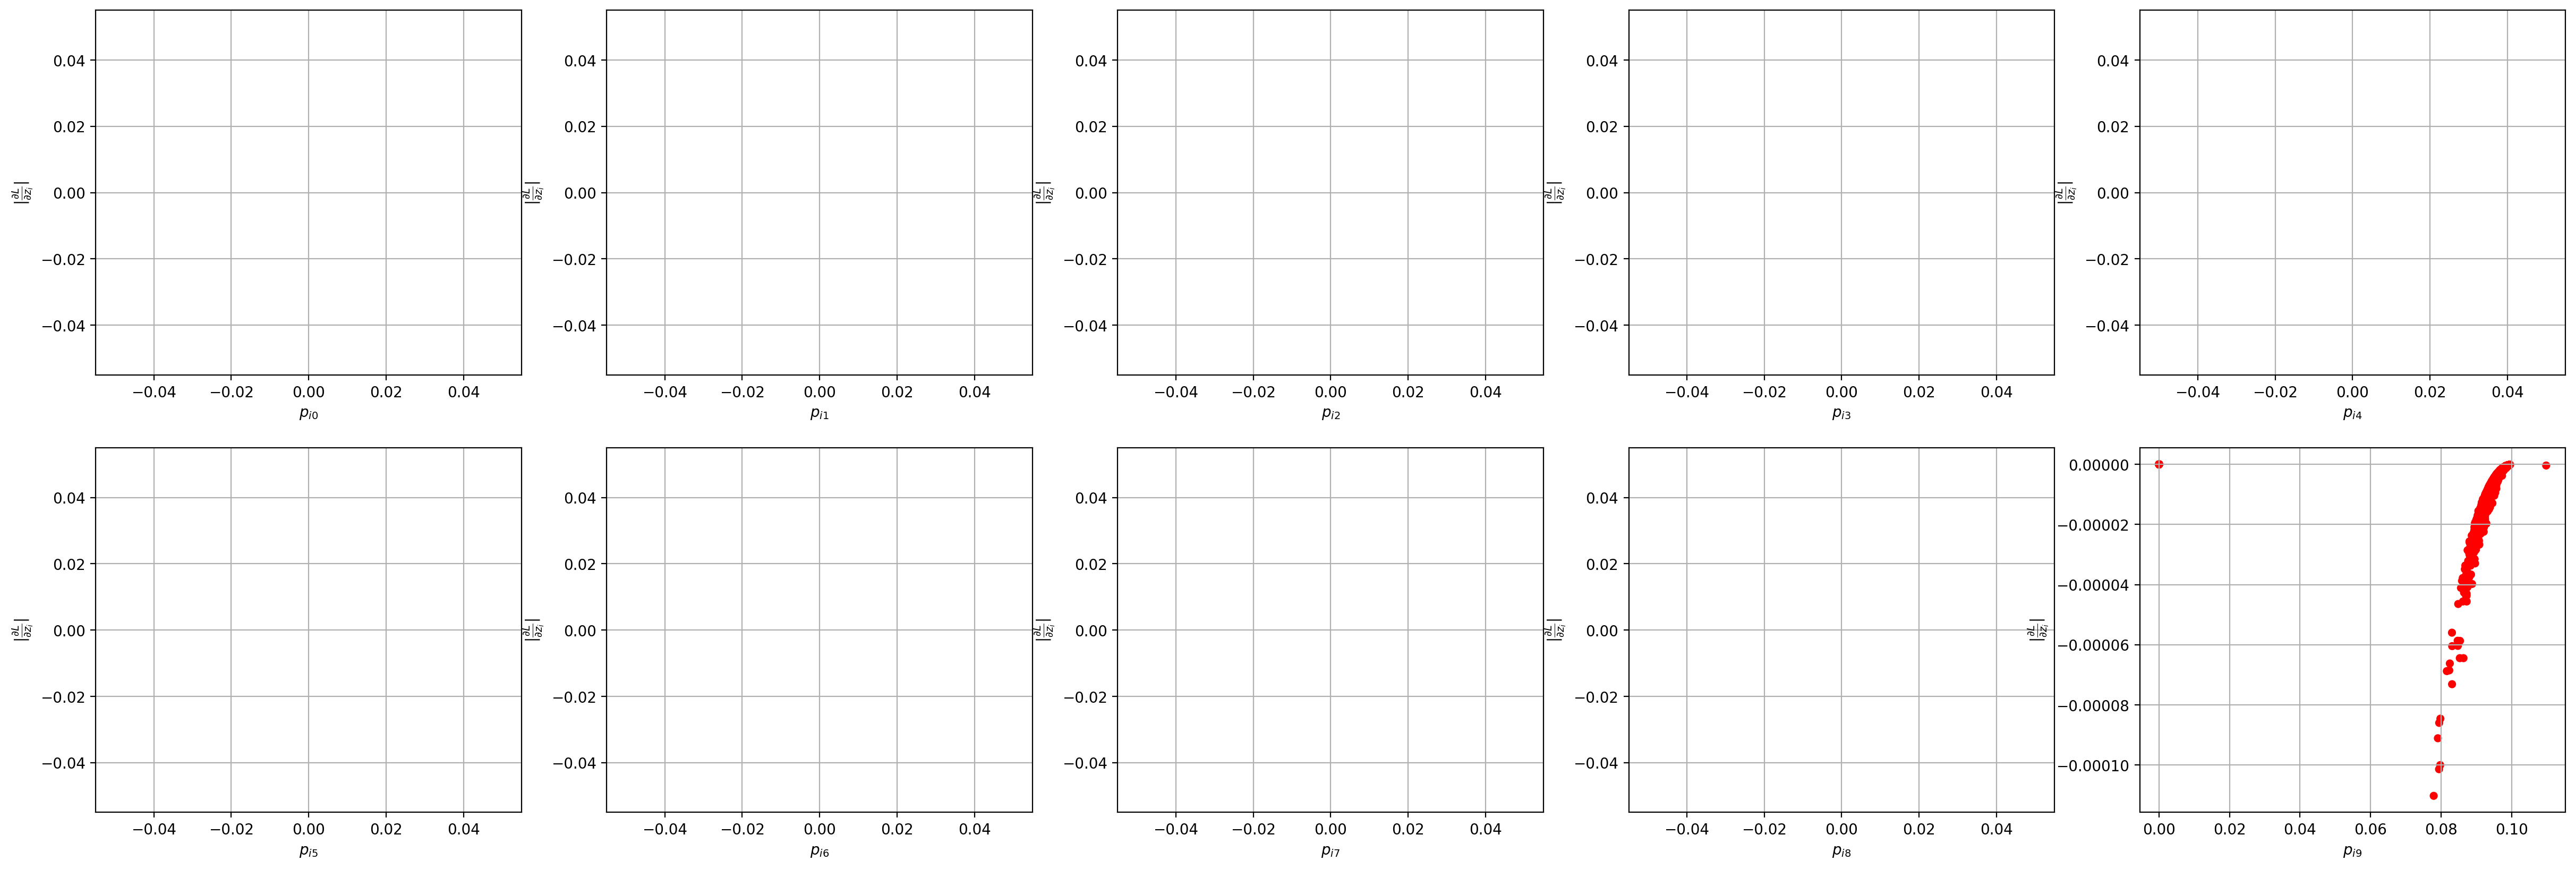

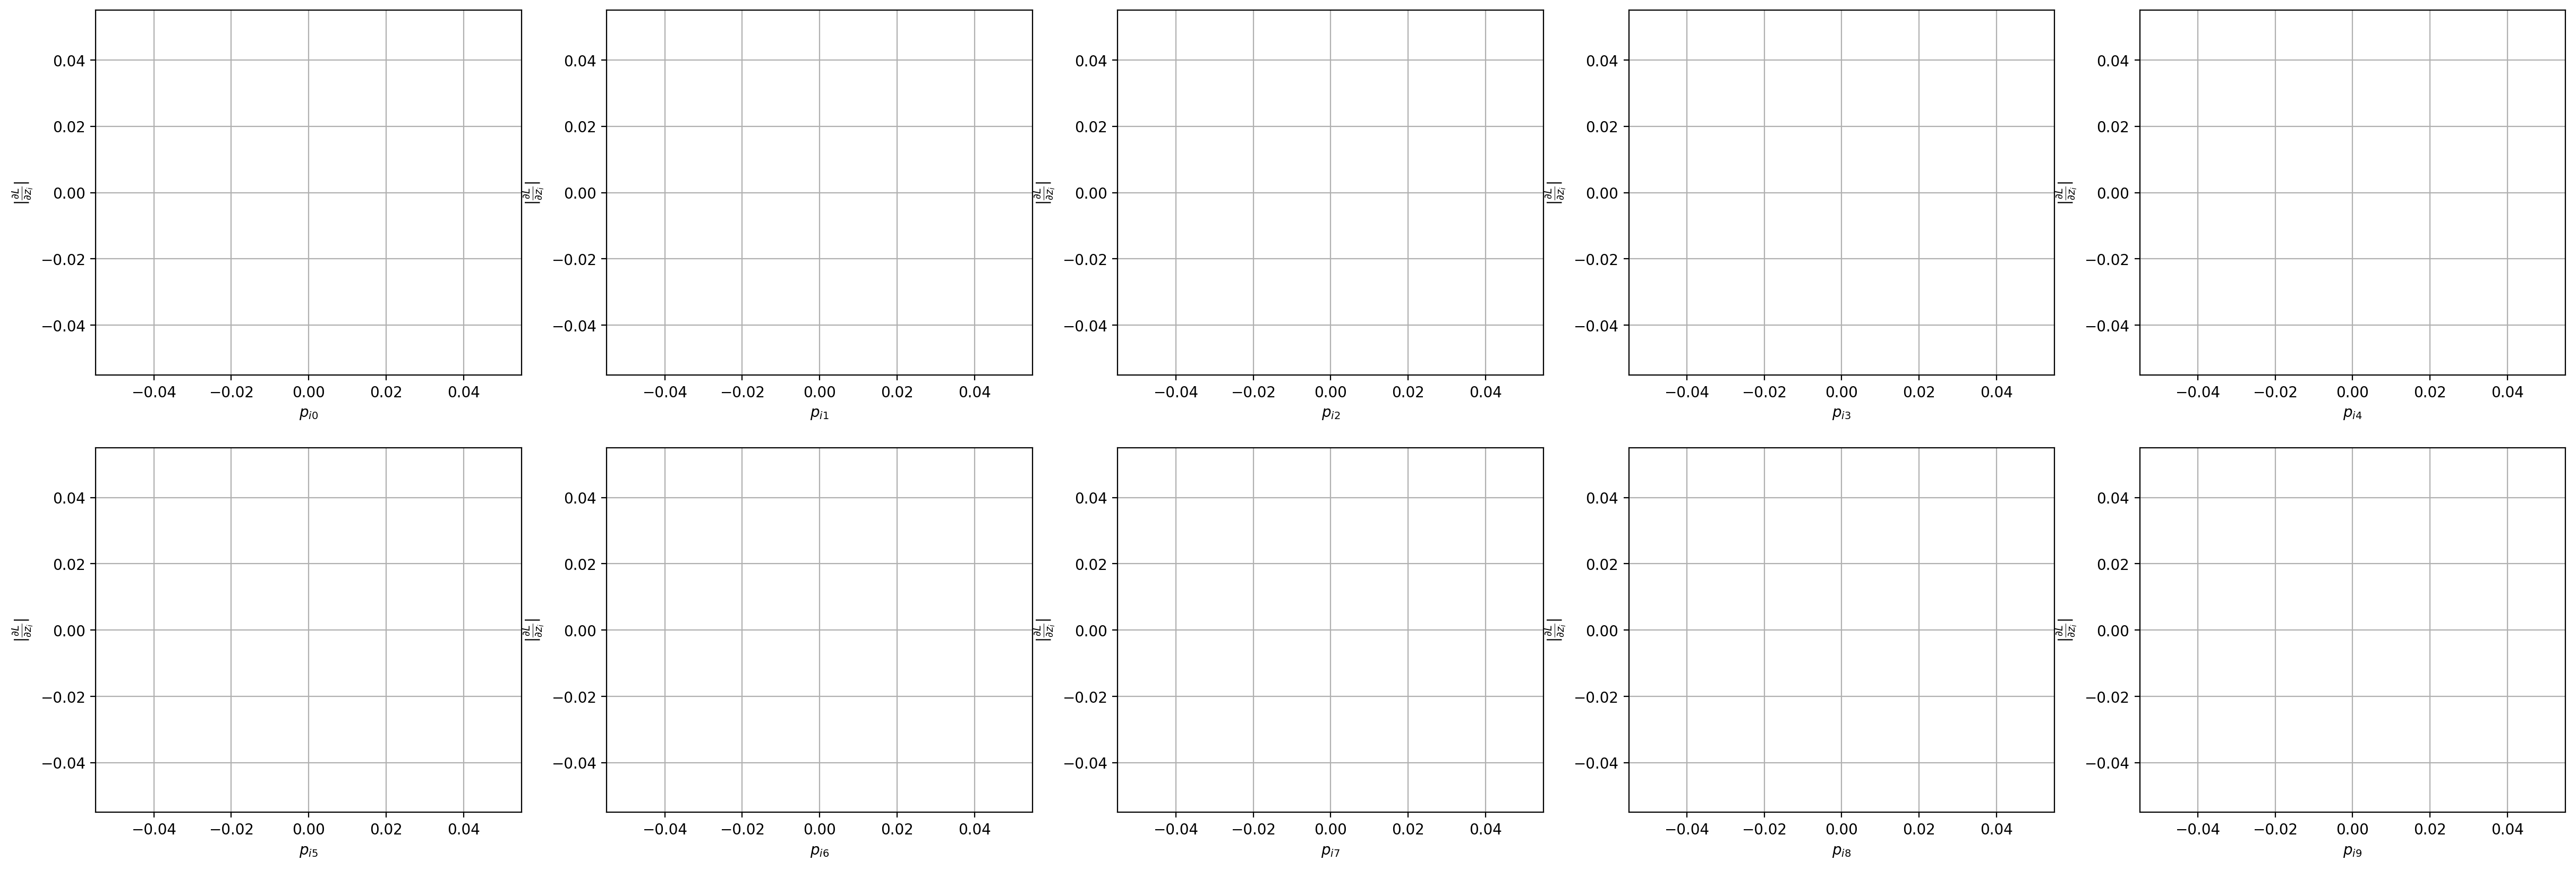

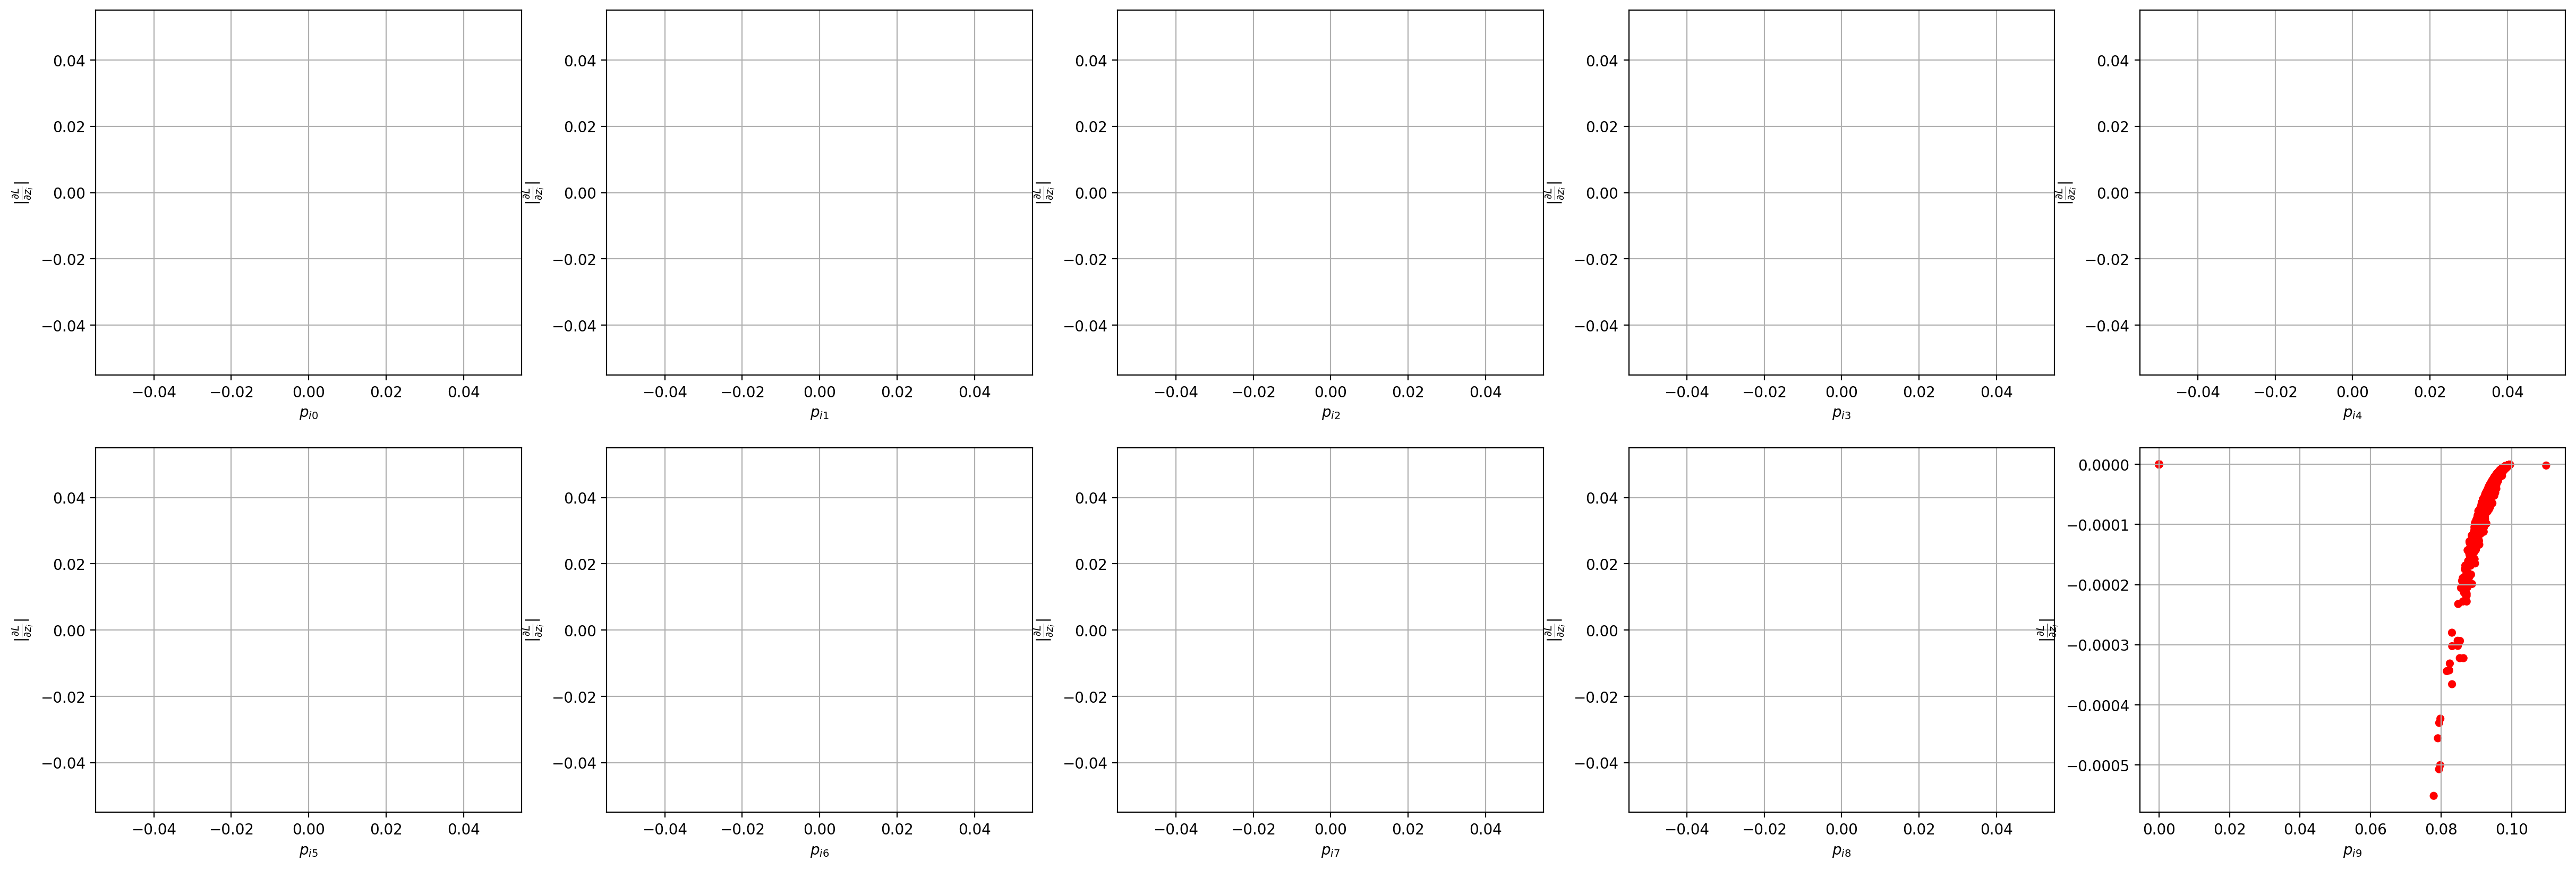

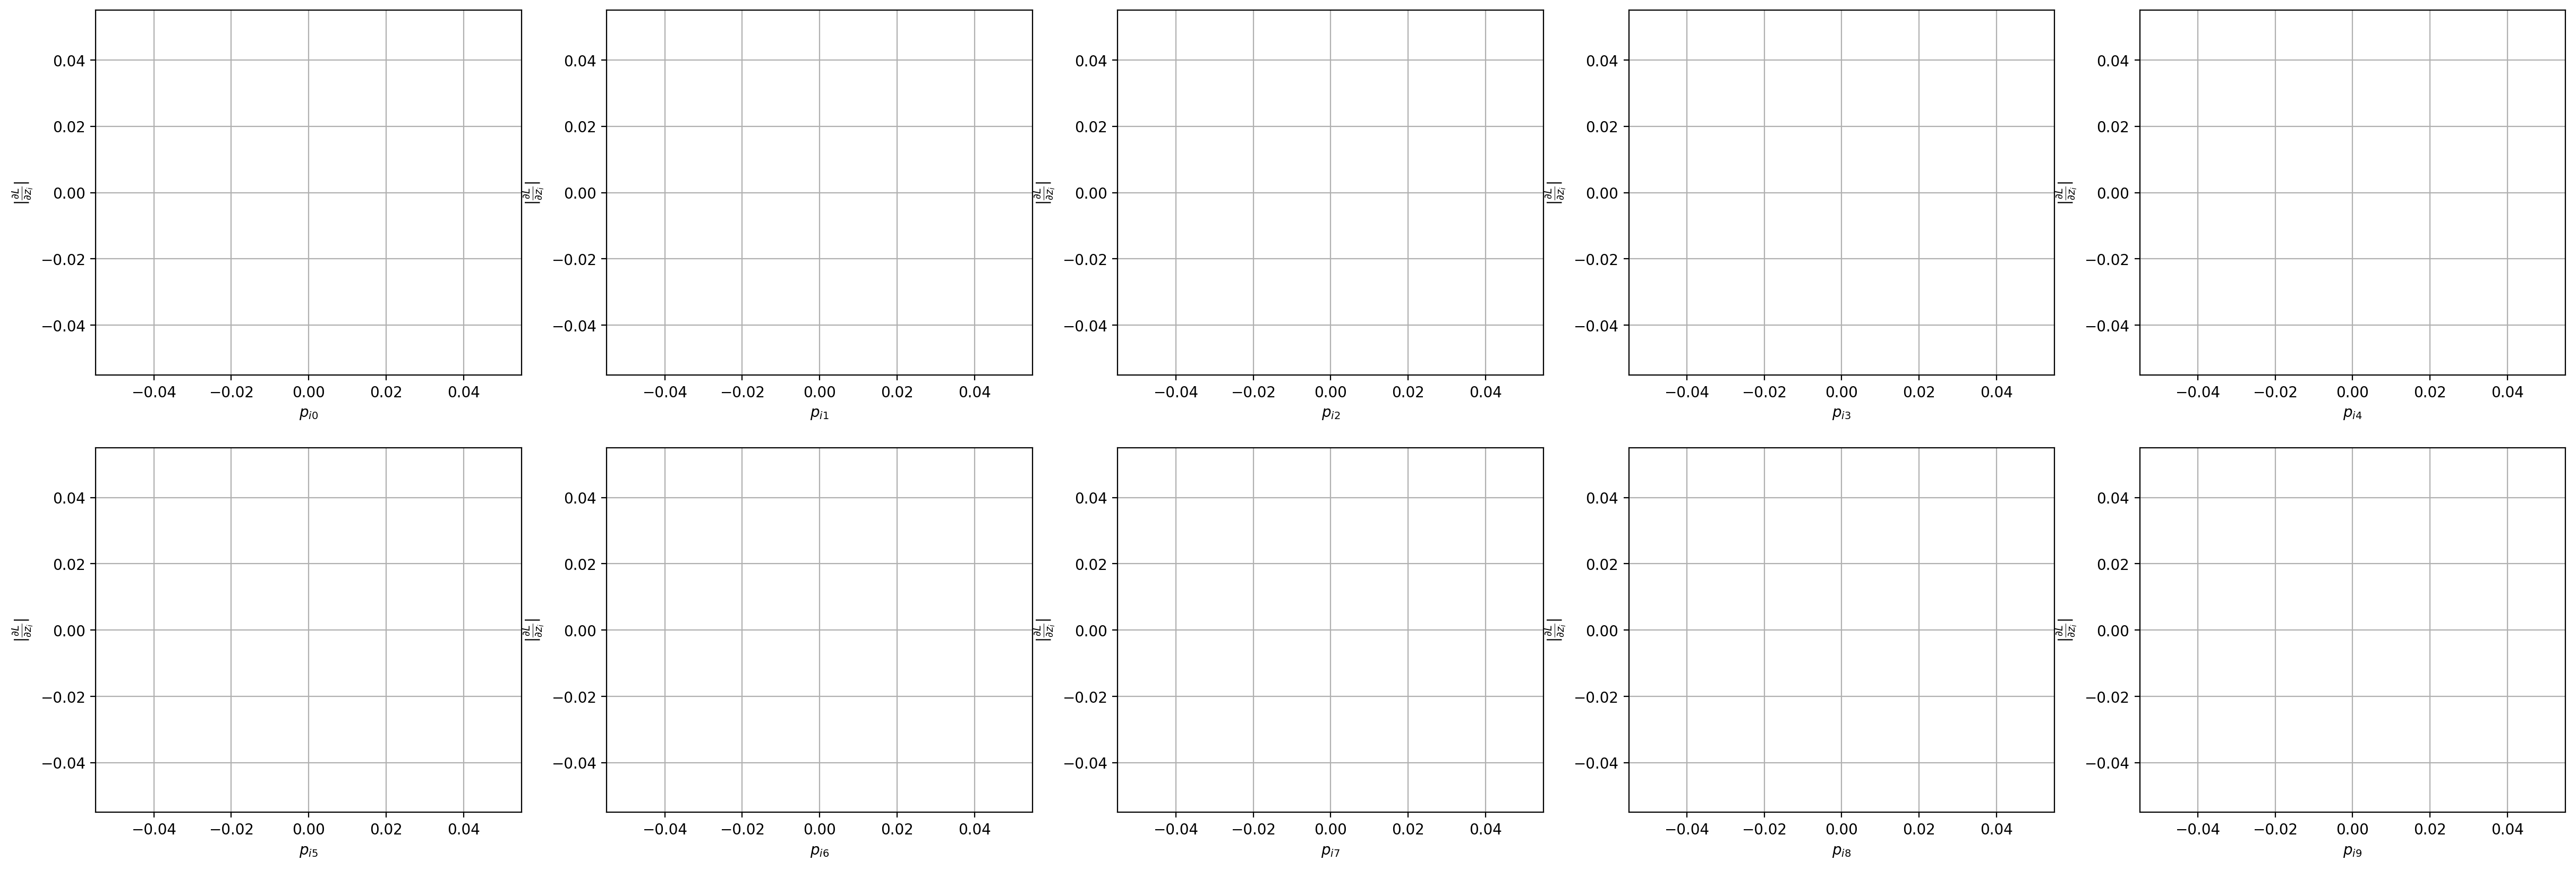

In [8]:
## Gradients plot
for alpha in [1, 9]:
    # set weights
    encoder.set_weights(encoder_ft_param)
    # initializing clustering model
    clustering_model = create_clustering_model(
        n_clusters=N_CLUSTERS,
        alpha=9,
        encoder=encoder)
    # compiling the clustering model (necessary for evaluating)
    clustering_model.compile(
        loss='kld')
    clustering_model.get_layer(
        name='clustering').set_weights([initial_centroids])
    cl_layer = clustering_model.get_layer(name='clustering')
    # get soft assignments
    q = clustering_model(x_train).numpy()
    p = target_distribution(q)
    initial_pred = q.argmax(1)

    # compute gradients
    z = encoder(x_train).numpy()
    qq = (q.T/q.sum(axis=1)).T
    pp = (qq**2)
    pp = (pp.T/pp.sum(axis=1)).T
    grad = ((alpha+1.0)/alpha)/(1.0+cdist(z, initial_centroids, 'sqeuclidean')/alpha)*(pp-qq)*cdist(z, initial_centroids, 'cityblock')

    fig, axs = plt.subplots(2, int(N_CLUSTERS/2),
                            figsize=(30, 10),
                            squeeze=True,
                            facecolor='white',
                            dpi=200)
    k=0
    ind = np.bincount(q.argmax(axis=1)).argmin()
    colors = cm.rainbow(np.linspace(0, 1, N_CLUSTERS))
    for i in range(2):
        for j in range(int(N_CLUSTERS/2)):
            idx = (initial_pred == k)
            ax = axs[i, j]
            scatter = ax.scatter(qq[idx, ind],
                                grad[idx, ind],
                                color=colors[k],
                                s=[20]*len(p[idx, k]),
                                )
            ax.set_xlabel(r'$p_{i%d}$' % k)
            ax.set_ylabel(r'$|\frac{\partial L}{\partial z_i}|$')
            ax.grid()
            k+=1
    plt.savefig(results_path/'initial_gradients_dec_alpha{}.png'.format(alpha),
                facecolor=fig.get_facecolor(),
                edgecolor='none')
            
            
    datapoints = tf.Variable(x_train, dtype=tf.float32)
    soft_assignments = tf.Variable(p)

    with tf.GradientTape() as tape:
        embedded_points = encoder(datapoints)
        outputs = cl_layer(embedded_points)
        kld = kl_divergence(soft_assignments, outputs)
        dc_da = tape.gradient(kld, embedded_points)

    norm_dc_da = np.linalg.norm(dc_da, axis=1)
        
    fig, axs = plt.subplots(2, int(N_CLUSTERS/2),
                            figsize=(30, 10),
                            squeeze=True,
                            facecolor='white',
                            dpi=200)
    k=0
    colors = cm.rainbow(np.linspace(0, 1, N_CLUSTERS))
    for i in range(2):
        for j in range(int(N_CLUSTERS/2)):
            idx = (initial_pred == k)
            ax = axs[i, j]
            scatter = ax.scatter(p[idx, k],
                                norm_dc_da[idx],
                                color=colors[k],
                                s=[20]*len(p[idx, k]),
                                )
            ax.set_xlabel(r'$p_{i%d}$' % k)
            ax.set_ylabel(r'$|\frac{\partial L}{\partial z_i}|$')
            ax.grid()
            k+=1
    plt.savefig(results_path/'initial_gradients_alpha{}.png'.format(alpha),
                facecolor=fig.get_facecolor(),
                edgecolor='none')

Visualizing dec labels


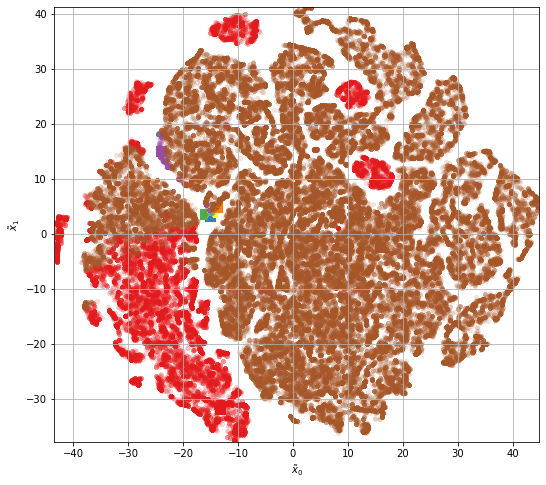

Visualizing kmeans labels


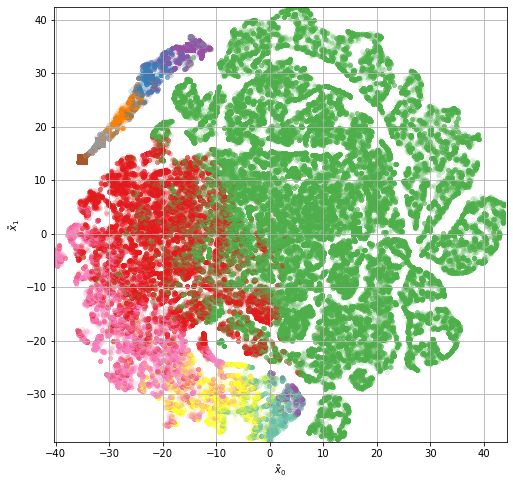

Visualizing ground_truth labels


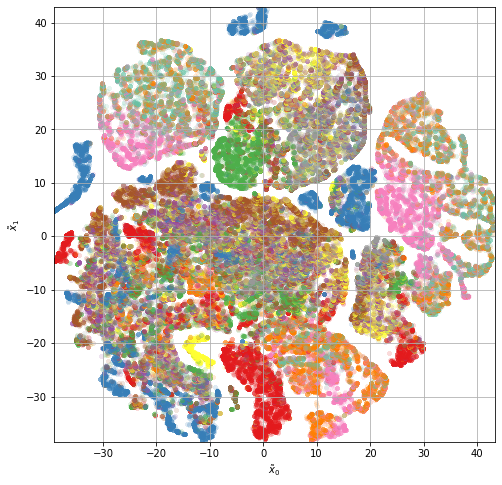

In [9]:
encoder.set_weights(encoder_final_param)
z = encoder(x_train).numpy()
delta = 1.0

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))
        a = np.concatenate((z, centroids), axis=0)
    
    tsne = TSNE(n_components=2,
                n_jobs=-1,
                random_state=51550).fit_transform(a)
    
    points = pd.DataFrame(tsne[:len(x_train)], columns=['x0', 'x1'])
    centroids = pd.DataFrame(tsne[len(x_train):], columns=['x0', 'x1'])
    centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, ax = plt.subplots(figsize=(16, 8))
    x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
    y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)
    
    agg = ds.count()
    cmap = None
    if centroids is not None:
        cmap = 'tab10'
        dsshow(df=centroids, glyph=ds.Point('x0','x1'), aggregator=ds.count_cat('y'), ax=ax,
            shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
        agg = ds.count_cat('y')
        
    artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
            shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
    #ax.legend(handles=artist.get_legend_elements())
    plt.grid()
    plt.xlabel(r'$\tilde{x}_0$')
    plt.ylabel(r'$\tilde{x}_1$')
    plt.savefig(results_path/'cluster_tsne_space_{}.png'.format(desc))
    plt.show()
    #plt.close()

Visualizing dec labels


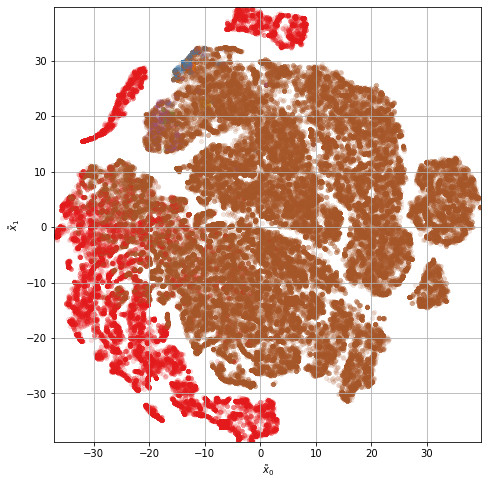

Visualizing kmeans labels


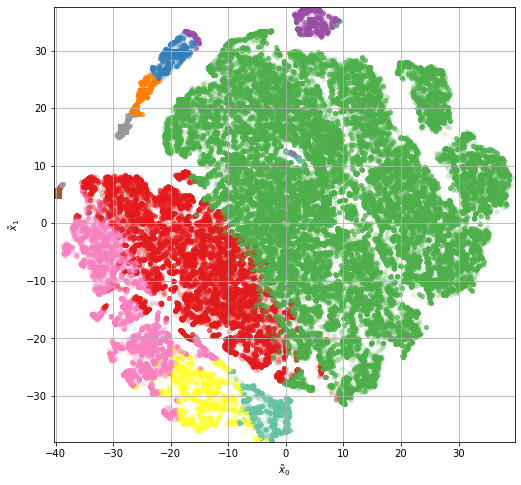

Visualizing ground_truth labels


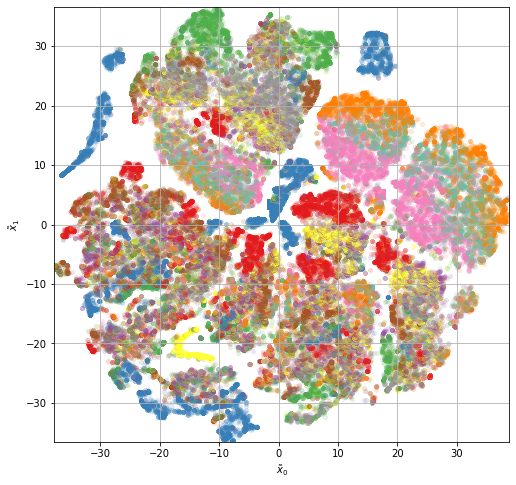

In [10]:
encoder.set_weights(encoder_ft_param)
z = encoder(x_train).numpy()
delta = 1.0

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))
        a = np.concatenate((z, centroids), axis=0)
    
    tsne = TSNE(n_components=2,
                n_jobs=-1,
                random_state=51550).fit_transform(a)
    
    points = pd.DataFrame(tsne[:len(x_train)], columns=['x0', 'x1'])
    centroids = pd.DataFrame(tsne[len(x_train):], columns=['x0', 'x1'])
    centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, ax = plt.subplots(figsize=(16, 8))
    x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
    y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)
    
    agg = ds.count()
    cmap = None
    if centroids is not None:
        cmap = 'tab10'
        dsshow(df=centroids, glyph=ds.Point('x0','x1'), aggregator=ds.count_cat('y'), ax=ax,
            shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
        agg = ds.count_cat('y')
        
    artist = dsshow(df=points, glyph=ds.Point('x0','x1'), aggregator=agg, ax=ax,
            shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
    #ax.legend(handles=artist.get_legend_elements())
    plt.grid()
    plt.xlabel(r'$\tilde{x}_0$')
    plt.ylabel(r'$\tilde{x}_1$')
    plt.savefig(results_path/'finetune_tsne_space_{}.png'.format(desc))
    plt.show()
    #plt.close()

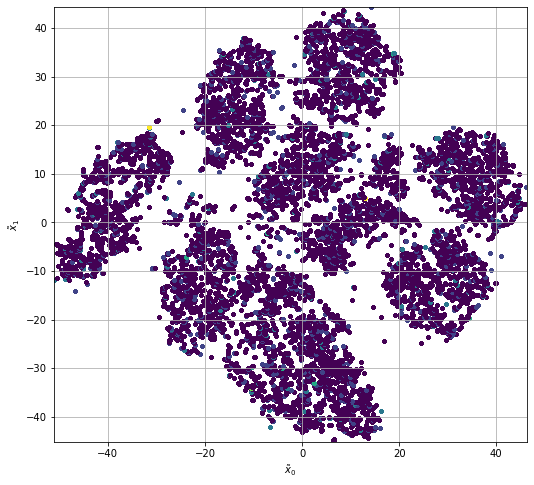

In [11]:
encoder.set_weights(encoder_param)
z = encoder(x_test).numpy()
delta = 1.0
tsne = TSNE(n_components=2, random_state=51550).fit_transform(z)
points = pd.DataFrame(tsne, columns=['x0', 'x1'])
fig, ax = plt.subplots(figsize=(16, 8))
x_range = (np.min(points['x0'])-delta, np.max(points['x0'])+delta)
y_range = (np.min(points['x1'])-delta, np.max(points['x1'])+delta)
artist = dsshow(points, ds.Point('x0','x1'), ds.count(), ax=ax,
      shade_hook=partial(dtf.spread, px=2), x_range=x_range, y_range=y_range)
ax.grid()
ax.set_xlabel(r'$\tilde{x}_0$')
ax.set_ylabel(r'$\tilde{x}_1$')
plt.savefig(results_path/'pretrain_tsne_space.png')
#plt.close()

In [13]:
encoder.set_weights(encoder_final_param)
z = encoder(x_train).numpy()
delta = 0.1
    
points = pd.DataFrame(z, columns=['z{}'.format(i) for i in range(10)])

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))
    
    centroids = pd.DataFrame(centroids, columns=['z{}'.format(i) for i in range(10)])
    centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, axs = plt.subplots(dims[-1], dims[-1],
                            figsize=(8*dims[-1], 4*dims[-1]),
                            squeeze=False,
                            facecolor='white',
                            dpi=200)
    for i in range(dims[-1]):
        for j in range(dims[-1]):
            ax = axs[i, j]
            x_range = (np.min(points['z{}'.format(i)])-delta, np.max(points['z{}'.format(i)])+delta)
            y_range = (np.min(points['z{}'.format(j)])-delta, np.max(points['z{}'.format(j)])+delta)
            if i!=j:
                agg = ds.count()
                cmap = None
                if centroids is not None:
                    cmap = 'tab10'
                    dsshow(df=centroids, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=ds.count_cat('y'), ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
                    agg = ds.count_cat('y')
                    
                artist = dsshow(df=points, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=agg, ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
                #ax.legend(handles=artist.get_legend_elements())
            ax.grid()
            ax.set_xlabel(r'$z_{%d}$' % i)
            ax.set_ylabel(r'$z_{%d}$' % j)
    plt.savefig(results_path/'cluster_feature_space_{}.png'.format(desc),
                facecolor=fig.get_facecolor(),
                edgecolor='none')
    plt.close()

Visualizing dec labels
Visualizing kmeans labels
Visualizing ground_truth labels


In [ ]:
encoder.set_weights(encoder_ft_param)
z = encoder(x_train).numpy()
delta = 0.1
    
points = pd.DataFrame(z, columns=['z{}'.format(i) for i in range(10)])

for labels, desc in zip(labels_list, descs_list):
    print('Visualizing {} labels'.format(desc))
    centroids = None
    if labels is not None:
        centroids = []
        n_clusters_found = len(np.unique(labels))
        for i in np.unique(labels):
            idx = (labels == i)
            centroids.append(compute_centroid_np(z[idx, :]))
    
    centroids = pd.DataFrame(centroids, columns=['z{}'.format(i) for i in range(10)])
    centroids['y'] = ['label {}'.format(l) for l in np.unique(labels)]
    centroids['y'] = centroids['y'].astype("category")
    points['y'] = ['label {}'.format(l) for l in labels]
    points['y'] = points['y'].astype("category")
    
    fig, axs = plt.subplots(dims[-1], dims[-1],
                            figsize=(8*dims[-1], 4*dims[-1]),
                            squeeze=False,
                            facecolor='white',
                            dpi=200)
    for i in range(dims[-1]):
        for j in range(dims[-1]):
            ax = axs[i, j]
            x_range = (np.min(points['z{}'.format(i)])-delta, np.max(points['z{}'.format(i)])+delta)
            y_range = (np.min(points['z{}'.format(j)])-delta, np.max(points['z{}'.format(j)])+delta)
            if i!=j:
                agg = ds.count()
                cmap = None
                if centroids is not None:
                    cmap = 'tab10'
                    dsshow(df=centroids, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=ds.count_cat('y'), ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=5, shape='square'), cmap=cmap, x_range=x_range, y_range=y_range)
                    agg = ds.count_cat('y')
                    
                artist = dsshow(df=points, glyph=ds.Point('z{}'.format(i),'z{}'.format(j)), aggregator=agg, ax=axs[i, j],
                      shade_hook=partial(dtf.spread, px=2), cmap=cmap, x_range=x_range, y_range=y_range)
                #ax.legend(handles=artist.get_legend_elements())
            ax.grid()
            ax.set_xlabel(r'$z_{%d}$' % i)
            ax.set_ylabel(r'$z_{%d}$' % j)
    plt.savefig(results_path/'finetune_feature_space_{}.png'.format(desc),
                facecolor=fig.get_facecolor(),
                edgecolor='none')
    plt.close()

Visualizing dec labels
Visualizing kmeans labels
Visualizing ground_truth labels


In [ ]:
encoder.set_weights(encoder_param)
z = encoder(x_test).numpy()
delta = 0.1
    
points = pd.DataFrame(z, columns=['z{}'.format(i) for i in range(10)])

fig, axs = plt.subplots(dims[-1], dims[-1],
                        figsize=(8*dims[-1], 4*dims[-1]),
                        squeeze=False,
                        facecolor='white',
                        dpi=200)
for i in range(dims[-1]):
    for j in range(dims[-1]):
        ax = axs[i, j]
        x_range = (np.min(points['z{}'.format(i)])-delta, np.max(points['z{}'.format(i)])+delta)
        y_range = (np.min(points['z{}'.format(j)])-delta, np.max(points['z{}'.format(j)])+delta)
        if i!=j:
            artist = dsshow(points, ds.Point('z{}'.format(i),'z{}'.format(j)), ds.count(), ax=axs[i, j],
                  shade_hook=partial(dtf.spread, px=2), x_range=x_range, y_range=y_range)
        ax.grid()
        ax.set_xlabel(r'$z_{%d}$' % i)
        ax.set_ylabel(r'$z_{%d}$' % j)
plt.savefig(results_path/'pretrain_feature_space_{}.png'.format(desc),
            facecolor=fig.get_facecolor(),
            edgecolor='none')
plt.close()

In [ ]:
## Example MNIST digits
figure = plt.figure(figsize=(20, 4), facecolor='white',)
j = 0

for example in x_train[:10]:
  plt.subplot(2, 5, j+1)
  plt.imshow(example.reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1
plt.savefig(results_path/'img_orig.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

In [ ]:
## Example MNIST digits from pretrained autoencoder
encoder.set_weights(encoder_param)
figure = plt.figure(figsize=(20, 4), facecolor='white',)
j = 0

for example in autoencoder(x_train[:10]):
  plt.subplot(2, 5, j+1)
  plt.imshow(example.numpy().reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1
plt.savefig(results_path/'img_r_pretrain.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

In [ ]:
## Example MNIST digits from finetuned autoencoder
encoder.set_weights(encoder_ft_param)
figure = plt.figure(figsize=(20, 4), facecolor='white',)
j = 0

for example in autoencoder(x_train[:10]):
  plt.subplot(2, 5, j+1)
  plt.imshow(example.numpy().reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1
plt.savefig(results_path/'img_r_finetune.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')

In [ ]:
## Example MNIST digits from final model
encoder.set_weights(encoder_final_param)
figure = plt.figure(figsize=(20, 4), facecolor='white',)
j = 0

for example in autoencoder(x_train[:10]):
  plt.subplot(2, 5, j+1)
  plt.imshow(example.numpy().reshape((28,28)), cmap='gray', aspect='equal')
  plt.axis('off')
  j += 1
plt.savefig(results_path/'img_r_final.png',
            facecolor=fig.get_facecolor(),
            edgecolor='none')